In [6]:
import numpy as np
import pandas as pd
from vnpy.app.cta_strategy.backtesting import BacktestingEngine, OptimizationSetting
from datetime import datetime
from dual_thrust_strategy import DualThrustStrategy
from trade_by_trade import (calculate_trades_result, generate_trade_df)
import matplotlib.pyplot as plt

In [8]:
engine = BacktestingEngine()
engine.set_parameters(
    vt_symbol="IF888.CFFEX",
    interval="1m",
    start=datetime(2014, 10, 1),
    end=datetime(2018, 12, 30),
    slippage=0.2,
    rate=0.3/10000,
    size=300,
    pricetick=0.2,
    capital=1_000_000,
)
engine.add_strategy(DualThrustStrategy, {})
engine.load_data()
engine.run_backtesting()

2020-04-15 15:40:29.022356	开始加载历史数据
2020-04-15 15:40:29.022356	加载进度： [2%]
2020-04-15 15:40:29.022356	加载进度： [4%]
2020-04-15 15:40:29.022356	加载进度： [6%]
2020-04-15 15:40:29.022356	加载进度： [8%]
2020-04-15 15:40:29.022356	加载进度： [10%]
2020-04-15 15:40:29.022356	加载进度：# [12%]
2020-04-15 15:40:29.022356	加载进度：# [14%]
2020-04-15 15:40:29.022356	加载进度：# [15%]
2020-04-15 15:40:29.022356	加载进度：# [17%]
2020-04-15 15:40:29.022356	加载进度：# [19%]
2020-04-15 15:40:29.022356	加载进度：## [21%]
2020-04-15 15:40:29.022356	加载进度：## [23%]
2020-04-15 15:40:29.022356	加载进度：## [25%]
2020-04-15 15:40:29.022356	加载进度：## [27%]
2020-04-15 15:40:29.022356	加载进度：## [29%]
2020-04-15 15:40:29.022356	加载进度：### [31%]
2020-04-15 15:40:29.022356	加载进度：### [33%]
2020-04-15 15:40:29.022356	加载进度：### [35%]
2020-04-15 15:40:29.022356	加载进度：### [37%]
2020-04-15 15:40:29.022356	加载进度：### [39%]
2020-04-15 15:40:29.022356	加载进度：#### [41%]
2020-04-15 15:40:29.022356	加载进度：#### [43%]
2020-04-15 15:40:29.022356	加载进度：#### [44%]
2020-04-15 15:40:29.022356	加载

In [9]:
trade_df_without_fee = generate_trade_df(engine.trades,size=1, rate=0, slippage=0,capital=100_00_00)
threshold_return = 0
model_accuracy_without_fee = np.sum(trade_df_without_fee['net_pnl']>threshold_return)/trade_df_without_fee['net_pnl'].shape[0]

In [12]:
trade_df_with_fee = generate_trade_df(engine.trades,size=1, rate=0.3/10000, slippage=0.6,capital=100_00_00)
threshold_return = 0
model_accuracy_with_fee = np.sum(trade_df_with_fee['net_pnl']>threshold_return)/trade_df_with_fee['net_pnl'].shape[0]

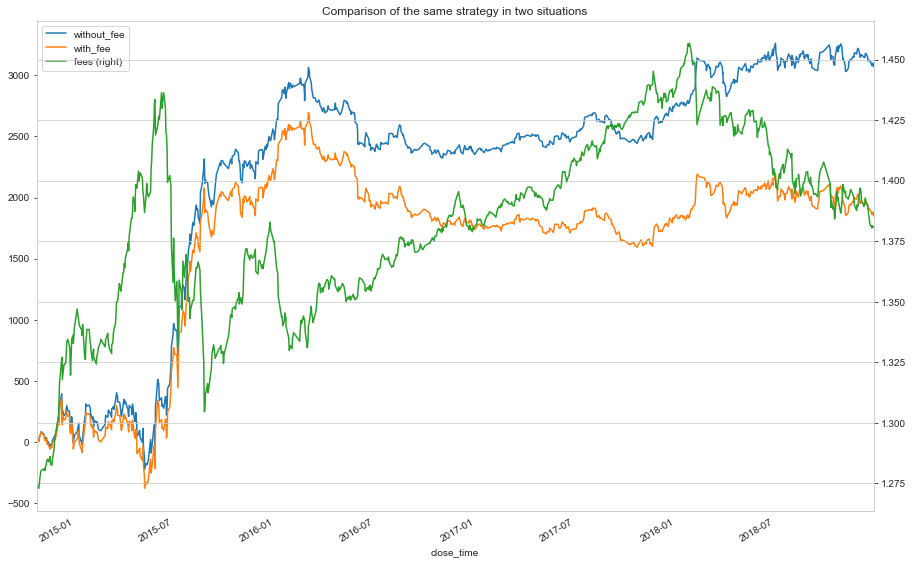

In [13]:
pnl_without_fee = trade_df_without_fee['acum_pnl'].values
pnl_with_fee = trade_df_with_fee['acum_pnl'].values
fees = (trade_df_with_fee['slipping']+trade_df_with_fee['commission']).values
two_pnl_df = pd.DataFrame({'without_fee':pnl_without_fee,'with_fee':pnl_with_fee,'fees': fees},index=trade_df_with_fee.close_time)
two_pnl_df[['without_fee','with_fee','fees']].plot(secondary_y='fees',figsize=(15,10),title='Comparison of the same strategy in two situations')

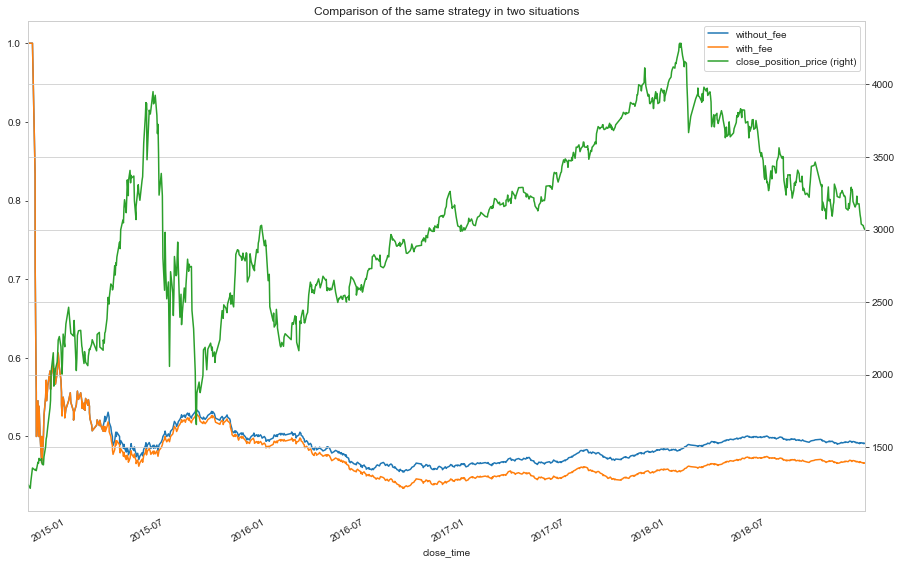

In [14]:
threshold = 0
side=np.where(trade_df_with_fee['close_direction']=='多',1,-1)
pnl_without_fee = trade_df_without_fee['net_pnl'].values
pnl_with_fee = trade_df_with_fee['net_pnl'].values
actual_with_fee = np.where(trade_df_with_fee['net_pnl']>threshold,1,0)
actual_without_fee = np.where(trade_df_without_fee['net_pnl']>0,1,0)
predict_with_fee = np.ones(shape=(trade_df_with_fee.shape[0],))
predict_num = predict_with_fee.cumsum()
actual_result_cum_with_fee = actual_with_fee.cumsum()
actual_result_cum_without_fee = actual_without_fee.cumsum()
accuracy_with_fee =  actual_result_cum_with_fee/predict_num
accuracy_without_fee =  actual_result_cum_without_fee/predict_num
close_position_price = trade_df_with_fee['close_price'].values
two_accuracy_df = pd.DataFrame({'without_fee':accuracy_without_fee,'with_fee':accuracy_with_fee,'close_position_price':close_position_price,
                                'side':side,'actual_with_fee':actual_with_fee,'actual_without_fee':actual_without_fee },index=trade_df_with_fee.close_time)
two_accuracy_df[['without_fee','with_fee','close_position_price']].plot(secondary_y='close_position_price',figsize=(15,10),title='Comparison of the same strategy in two situations')

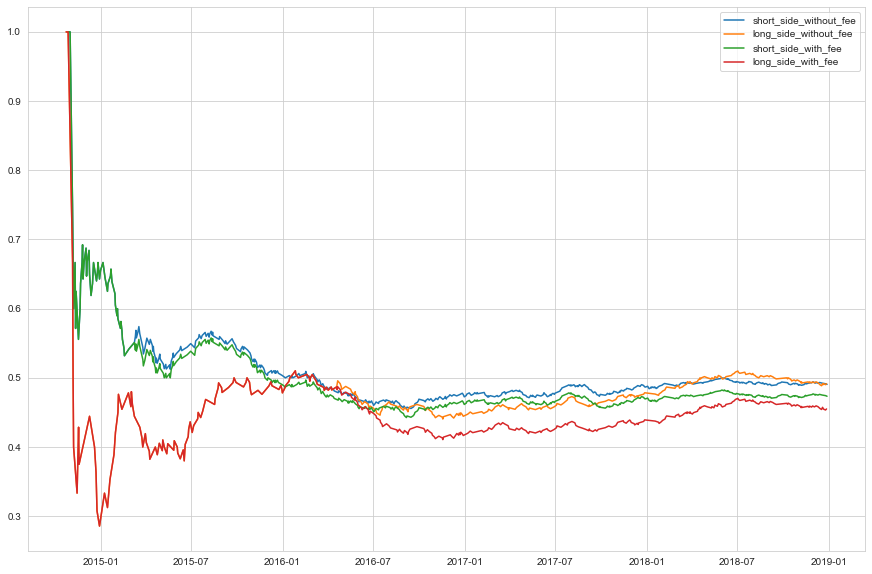

In [21]:
two_accuracy_df['num'] = 1
long_side = two_accuracy_df[two_accuracy_df['side']==1]
short_side = two_accuracy_df[two_accuracy_df['side']==-1]
long_accuracy_with_fee = long_side['actual_with_fee'].cumsum()/long_side['num'].cumsum()
long_accuracy_without_fee = long_side['actual_without_fee'].cumsum()/long_side['num'].cumsum()
short_accuracy_with_fee = short_side['actual_with_fee'].cumsum()/short_side['num'].cumsum()
short_accuracy_without_fee = short_side['actual_without_fee'].cumsum()/short_side['num'].cumsum()
figure = plt.figure(figsize=(15,10))
plt.plot(short_accuracy_without_fee,label='short_side_without_fee')
plt.plot(long_accuracy_without_fee, label='long_side_without_fee')
plt.plot(short_accuracy_with_fee,label='short_side_with_fee')
plt.plot(long_accuracy_with_fee,label='long_side_with_fee')

plt.legend()

<Figure size 1080x720 with 0 Axes>

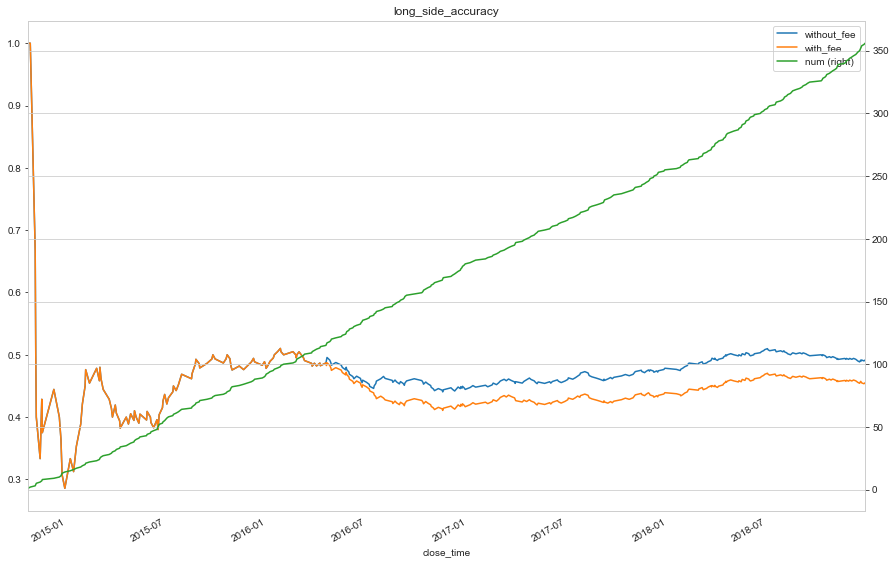

In [22]:
figure = plt.figure(figsize=(15,10))
long_accuracy_df = pd.DataFrame({'with_fee':long_accuracy_with_fee.values,'without_fee':long_accuracy_without_fee,'num':long_side['num'].cumsum()})
# plt.plot(long_accuracy_without_fee, label='long_side_without_fee')
# plt.plot(long_accuracy_with_fee,label='long_side_with_fee')
# plt.legend()
long_accuracy_df[['without_fee','with_fee','num']].plot(secondary_y='num',figsize=(15,10),title='long_side_accuracy')

<Figure size 1080x720 with 0 Axes>

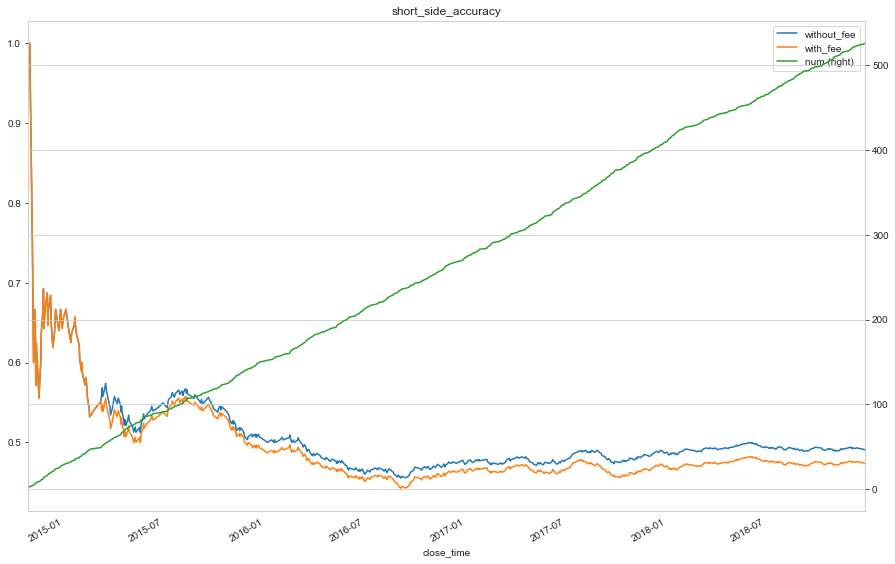

In [23]:
figure = plt.figure(figsize=(15,10))
short_accuracy_df = pd.DataFrame({'with_fee':short_accuracy_with_fee.values,'without_fee':short_accuracy_without_fee,'num':short_side['num'].cumsum()})
# plt.plot(long_accuracy_without_fee, label='long_side_without_fee')
# plt.plot(long_accuracy_with_fee,label='long_side_with_fee')
# plt.legend()
short_accuracy_df[['without_fee','with_fee','num']].plot(secondary_y='num',figsize=(15,10),title='short_side_accuracy')

In [24]:
quantile = 0.75
quantile_index = int(trade_df_with_fee['net_pnl'].shape[0]*quantile)
trade_df_without_fee_sort = trade_df_without_fee['net_pnl'].sort_values()
quantile_trade_df_without_fee_sort=trade_df_without_fee_sort[quantile_index:]
quantitle_75_return_mean_without_fee = quantile_trade_df_without_fee_sort.mean()
quantitle_75_return_count_without_fee = quantile_trade_df_without_fee_sort.count()
quantile_trade_df_without_fee_sort.describe()

count    221.000000
mean      59.610860
std       49.591787
min       16.800000
25%       27.000000
50%       44.800000
75%       72.200000
max      332.400000
Name: net_pnl, dtype: float64

In [25]:
quantile = 0.75
quantile_index = int(trade_df_with_fee['net_pnl'].shape[0]*quantile)
trade_df_with_fee_sort = trade_df_with_fee['net_pnl'].sort_values()
quantile_trade_df_with_fee_sort=trade_df_with_fee_sort[quantile_index:]
quantitle_75_return_mean_with_fee = quantile_trade_df_with_fee_sort.mean()
quantitle_75_return_count_with_fee = quantile_trade_df_with_fee_sort.count()
quantile_trade_df_with_fee_sort.describe()

count    221.000000
mean      58.230763
std       49.599320
min       15.400176
25%       25.561878
50%       43.444492
75%       70.865570
max      331.065804
Name: net_pnl, dtype: float64

In [26]:
quantile = 0.25
quantile_index = int(trade_df_with_fee['net_pnl'].shape[0]*quantile)
trade_df_without_fee_sort = trade_df_without_fee['net_pnl'].sort_values()
quantile_trade_df_without_fee_sort=trade_df_without_fee_sort[:quantile_index]
quantitle_25_return_mean_without_fee = quantile_trade_df_without_fee_sort.mean()
quantitle_25_return_count_without_fee = quantile_trade_df_without_fee_sort.count()
quantile_trade_df_without_fee_sort.describe()

count    220.000000
mean     -45.165455
std       34.281604
min     -270.400000
25%      -50.050000
50%      -35.400000
75%      -24.350000
max      -18.000000
Name: net_pnl, dtype: float64

In [27]:
quantile = 0.25
quantile_index = int(trade_df_with_fee['net_pnl'].shape[0]*quantile)
trade_df_with_fee_sort = trade_df_with_fee['net_pnl'].sort_values()
quantile_trade_df_with_fee_sort=trade_df_with_fee_sort[:quantile_index]
quantitle_25_return_mean_with_fee = quantile_trade_df_with_fee_sort.mean()
quantitle_25_return_count_with_fee = quantile_trade_df_with_fee_sort.count()
quantile_trade_df_with_fee_sort.describe()

count    220.000000
mean     -46.542281
std       34.277399
min     -271.731484
25%      -51.378570
50%      -36.797040
75%      -25.735599
max      -19.392504
Name: net_pnl, dtype: float64

In [28]:
quantile_start = 0.25
quantile_end = 0.75
quantile_index_start = int(trade_df_with_fee['net_pnl'].shape[0]*quantile_start)
quantile_index_end = int(trade_df_with_fee['net_pnl'].shape[0]*quantile_end)
trade_df_without_fee_sort = trade_df_without_fee['net_pnl'].sort_values()
quantile_trade_df_without_fee_sort=trade_df_without_fee_sort[quantile_index_start:quantile_index_end]
quantitle_25_75_return_mean_without_fee = quantile_trade_df_without_fee_sort.mean()
quantitle_25_75_return_count_without_fee = quantile_trade_df_without_fee_sort.count()
quantile_trade_df_without_fee_sort.describe()

count    441.000000
mean      -0.378685
std        9.212472
min      -17.800000
25%       -7.600000
50%       -0.400000
75%        7.000000
max       16.800000
Name: net_pnl, dtype: float64

In [29]:
quantile_start = 0.25
quantile_end = 0.75
quantile_index_start = int(trade_df_with_fee['net_pnl'].shape[0]*quantile_start)
quantile_index_end = int(trade_df_with_fee['net_pnl'].shape[0]*quantile_end)
trade_df_without_fee_sort = trade_df_without_fee['net_pnl'].sort_values()
quantile_trade_df_with_fee_sort=trade_df_with_fee_sort[quantile_index_start:quantile_index_end]
quantitle_25_75_return_mean_with_fee = quantile_trade_df_with_fee_sort.mean()
quantitle_25_75_return_count_with_fee = quantile_trade_df_with_fee_sort.count()
quantile_trade_df_with_fee_sort.describe()

count    441.000000
mean      -1.767442
std        9.210414
min      -19.221934
25%       -8.992960
50%       -1.759444
75%        5.608198
max       15.378024
Name: net_pnl, dtype: float64

In [54]:
def calculate_minutes(duration:pd.Series)->pd.Series:
    return duration.total_seconds()/60
hold_duration = trade_df_with_fee['duration'].apply(calculate_minutes)

In [55]:
hold_duration.describe()

count    882.000000
mean     206.480726
std      108.859844
min        1.000000
25%       91.000000
50%      245.000000
75%      301.000000
max      340.000000
Name: duration, dtype: float64